## *Data Modelling*

In [ ]:
%run C:\Users\Omar\Siteck\Pyhton_Projects\demand_sales_data_Analysi\NoteBooks\2.Data_Cleaning.ipynb

### *Regression Modelling for Total_sales as a Target Features*

---

#### * *create dummies varibales :*

In [2]:
dummies=pd.get_dummies(df.select_dtypes(include="object"))

In [3]:
dummies=dummies.applymap(lambda x:1 if x is True else 0)

> ### Important Notes: 
> - we got 4904 columns ,this is due to high number of unique values for (order_id) and (customer_id) features
> - so to reduce the complexity and machine consumption , will drop these features

In [4]:
dummies_new=pd.get_dummies(df.select_dtypes(include="object").drop(["order_id","customer_id"],axis=1))

In [5]:
df1=df.select_dtypes(exclude="object").drop(["date","month","day","price_per_case","quantity"],axis=1)
dummies_new=dummies_new.applymap(lambda x:1 if x is True else 0)

#### *F2. Concatinate the dummies features with the dataset and drop the existed string features :*

In [6]:
df2=pd.concat([df1,dummies_new],axis=1)

In [7]:
df2.head()

,company,total_sales,company_region_North,company_region_South,product_id_11133,product_id_11177,product_id_11385,product_id_11501,product_id_11541,product_id_11829,...,month_name_November,month_name_October,month_name_September,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,121,9184,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,131,18216,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,131,6660,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,121,6150,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,121,14406,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


### *Basic Models Comparison :*


In [11]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Decision Tree": DecisionTreeRegressor(random_state=41),
                "Gradient Boosting": GradientBoostingRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

In [12]:

x_total_sales=df2.drop("total_sales",axis=1)
y_total_sales=df2["total_sales"]
xtrain_full,xtest_full, ytrain, ytest = train_test_split(x_total_sales, y_total_sales, train_size=0.8, test_size=0.2,random_state=0)

numerical_cols = [col for col in xtrain_full.columns if xtrain_full[col].dtype in ['int64', 'float64']]
categorical_cols =[col for col in xtrain_full.columns if  xtrain_full[col].dtype == "object"]

my_cols = categorical_cols + numerical_cols
xtrain = xtrain_full[my_cols].copy()
xtest = xtest_full[my_cols].copy()

numerical_transformer = Pipeline(steps=[
    ("scaler",StandardScaler())
    ])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ("scaler",StandardScaler(with_mean=False))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [13]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


model_list = []
r2_list =[]
mae_list=[]
rmse_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model =my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('melbourne_model', model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
    model.fit(xtrain, ytrain) 

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)
    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Root Mean Squared Error: 5387.4749
- Mean Absolute Error: 3234.7517
- R2 Score: 0.9407
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8414.6734
- Mean Absolute Error: 4218.6615
- R2 Score: 0.8153


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 4777.7290
- Mean Absolute Error: 3005.3914
- R2 Score: 0.9533
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 8610.1736
- Mean Absolute Error: 4312.9008
- R2 Score: 0.8066


Gradient Boosting
Model performance for Training set
- Root Mean Squared Error: 8331.0825
- Mean Absolute Error: 4624.7300
- R2 Score: 0.8581
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 9344.3153
- Mean Absolute Error: 4668.0800
- R2 Score: 0.7722


XGBRFRegressor
Model performance for Training set
- Root Mean Squared Error: 7004.0177
- Mean Absolute Error: 4

* *Best Model :* 

In [14]:
pd.DataFrame(list(zip(model_list,rmse_list,mae_list,r2_list)), 
             columns=['Model Name', 'rmse_Score','mae_Score','r2_Score']).sort_values(by=["mae_Score"],ascending=True)

,Model Name,rmse_Score,mae_Score,r2_Score
4,CatBoosting Regressor,8364.158876,3999.982088,0.817499
3,XGBRFRegressor,8023.659177,4089.867112,0.832056
0,Random Forest,8414.673438,4218.661488,0.815288
1,Decision Tree,8610.173639,4312.900817,0.806605
2,Gradient Boosting,9344.315250,4668.079955,0.772220
5,AdaBoost Regressor,10677.128500,6004.403905,0.702608


In [15]:
CatBoostRegressor_model = CatBoostRegressor(verbose=False,random_state=41)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', CatBoostRegressor_model)# or ('melbourne_model', RandomForestRegressor(random_state=0,n_estimators=50)) 
                             ])
my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

MAE: 3999.982087827889
 Accuracy of the model is 81.75


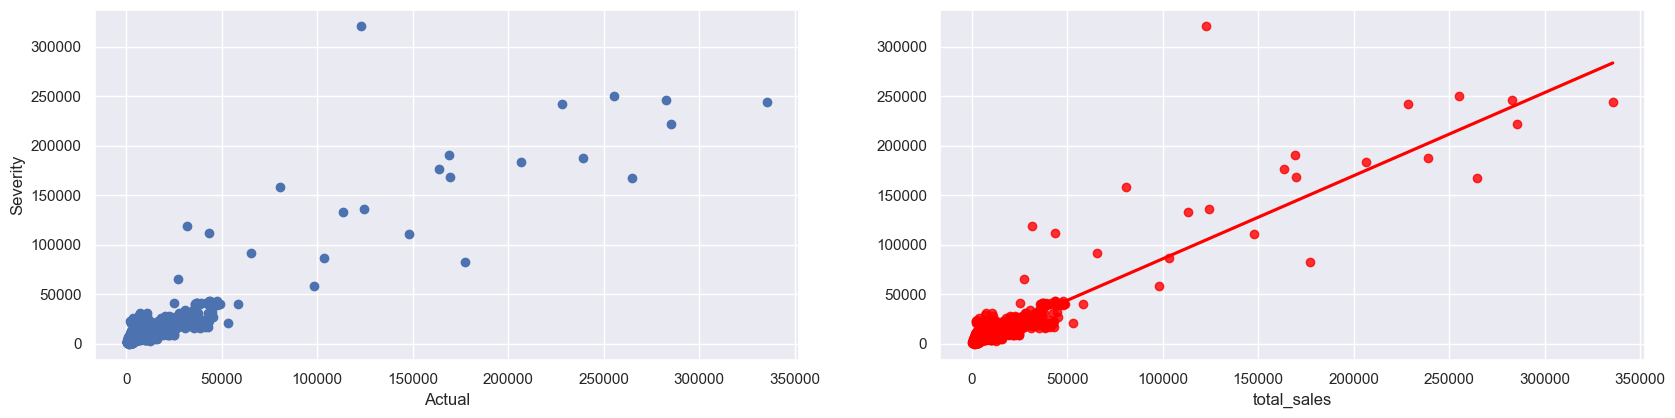

In [16]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('Severity');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---

### *Hyperopt Models Comparison :*

In [17]:
space_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_SVR = {
    'C': hp.loguniform('C', -5, 2), 
    'epsilon': hp.loguniform('epsilon', -3, 0), 
    'kernel': hp.choice('kernel', ['linear', 'rbf']) 

}

space_dt = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
    }

space_XGBRFRegressor = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

space_catboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
}

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

space_gradientboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 12)),
}

In [18]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"])                                                       
                                    #criterion=str(space_rf['criterion'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }   


#####################################################################

def model_gboost(space_gradientboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(space_gradientboost['n_estimators']),
                                    learning_rate=float(space_gradientboost["learning_rate"]),                                           
                                    max_depth=int(space_gradientboost['max_depth'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

#####################################################################

def model_XGBRFRegressor(space_XGBRFRegressor):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(space_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(space_XGBRFRegressor['max_depth']),
                                    num_parallel_tree=int(space_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(space_XGBRFRegressor['subsample'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }       

#####################################################################

def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 


In [19]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=50)
best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=50)
best_model_gboost = fmin(fn=model_gboost, space=space_gradientboost, algo=tpe.suggest, max_evals=50)
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=50)
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]0:	learn: 19777.4651617	total: 4.58ms	remaining: 903ms
1:	learn: 17710.6726157	total: 8.27ms	remaining: 810ms
2:	learn: 15977.5115716	total: 14.8ms	remaining: 959ms
3:	learn: 14529.2307117	total: 31.6ms	remaining: 1.53s
4:	learn: 13379.0553863	total: 38.6ms	remaining: 1.49s
5:	learn: 12395.2524830	total: 53.6ms	remaining: 1.72s
6:	learn: 11579.0951073	total: 56.9ms	remaining: 1.55s
7:	learn: 10792.8768778	total: 60.5ms	remaining: 1.44s
8:	learn: 10173.0972264	total: 66.2ms	remaining: 1.39s
9:	learn: 9620.2956687	total: 82.3ms	remaining: 1.55s
10:	learn: 9169.8176094	total: 90.2ms	remaining: 1.53s
11:	learn: 8808.8459938	total: 105ms	remaining: 1.63s
12:	learn: 8491.2495020	total: 121ms	remaining: 1.72s
13:	learn: 8215.4654532	total: 159ms	remaining: 2.09s
14:	learn: 7977.2441514	total: 211ms	remaining: 2.57s
15:	learn: 7768.4973784	total: 229ms	remaining: 2.61s
16:	learn: 7595.6250128	total: 249ms	remaining: 2.65s
17:	learn: 7424.27

In [20]:
print("best_model_catboost",best_model_catboost)
print("best_model_rf",best_model_rf)
print("best_model_gboost",best_model_gboost)
print("best_model_XGBRFRegressor",best_model_XGBRFRegressor)
print("best_model_adaboost",best_model_adaboost)

best_model_catboost {'depth': 8, 'iterations': 47, 'learning_rate': 0.168554488842566}
best_model_rf {'criterion': 1, 'max_depth': 8, 'n_estimators': 26}
best_model_gboost {'learning_rate': 0.09418137499487773, 'max_depth': 6, 'n_estimators': 6}
best_model_XGBRFRegressor {'colsample_bynode': 0.8316983223054288, 'learning_rate': 0.9924793632267228, 'max_depth': 11, 'subsample': 0.5084549019383966}
best_model_adaboost {'learning_rate': 0.45158229330497235, 'n_estimators': 91}


In [21]:
def model_catboost_best(best_model_catboost ):
    y_CatBoostRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_model_catboost ['learning_rate']),
                                    depth=int(best_model_catboost ["depth"]),                                                       
                                    iterations=int(best_model_catboost ['iterations'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_CatBoostRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_catboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_catboost_best is %.2f" %score)

#####################################################################

def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"])                                                       
                                    #criterion=str(best_model_rf['criterion'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) 

#####################################################################

def model_gboost_best(best_model_gboost):
    y_gboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("GradientBoostingRegressor",GradientBoostingRegressor(
                                    n_estimators=int(best_model_gboost['n_estimators']),
                                    learning_rate=float(best_model_gboost["learning_rate"]),                                           
                                    max_depth=int(best_model_gboost['max_depth'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    y_pred = model_opt_best.predict(xtest)
    y_gboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_gboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_gboost_best is %.2f" %score)

#####################################################################

def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

#####################################################################

def model_adaboost_best(best_model_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_model_adaboost['n_estimators']),
                                    learning_rate=float(best_model_adaboost["learning_rate"])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_adaboost_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_adaboost_best is %.2f" %score)

In [22]:
model_catboost_best(best_model_catboost)

0:	learn: 19465.9731539	total: 4.51ms	remaining: 207ms
1:	learn: 17179.3291965	total: 13.6ms	remaining: 307ms
2:	learn: 15312.1554485	total: 20ms	remaining: 294ms
3:	learn: 13783.3863377	total: 27.5ms	remaining: 295ms
4:	learn: 12684.1941007	total: 33.7ms	remaining: 283ms
5:	learn: 11584.9960257	total: 41ms	remaining: 280ms
6:	learn: 10775.4174511	total: 47.4ms	remaining: 271ms
7:	learn: 10054.5647300	total: 55.1ms	remaining: 268ms
8:	learn: 9504.7628848	total: 61.5ms	remaining: 260ms
9:	learn: 9001.6061821	total: 67ms	remaining: 248ms
10:	learn: 8611.4051089	total: 73.8ms	remaining: 241ms
11:	learn: 8294.4523107	total: 79.9ms	remaining: 233ms
12:	learn: 8033.3122204	total: 86.5ms	remaining: 226ms
13:	learn: 7830.5376352	total: 92.3ms	remaining: 218ms
14:	learn: 7668.9701663	total: 98.3ms	remaining: 210ms
15:	learn: 7540.4507890	total: 106ms	remaining: 205ms
16:	learn: 7434.8482658	total: 111ms	remaining: 197ms
17:	learn: 7326.1107483	total: 117ms	remaining: 188ms
18:	learn: 7241.62989

In [23]:

model_rf_best(best_model_rf)
model_gboost_best(best_model_gboost)
model_XGBRFRegressor_best(best_model_XGBRFRegressor)
model_adaboost_best(best_model_adaboost)

model_rf_best MAE: 3962.793343127002
 Accuracy of the model_rf_best is 83.69
model_gboost_best MAE: 6181.362633599729
 Accuracy of the model_gboost_best is 57.46
model_XGBRFRegressor_best MAE: 3929.6855702072226
 Accuracy of the model_XGBRFRegressor_best is 83.44
model_adaboost_best MAE: 5887.708739328326
 Accuracy of the model_adaboost_best is 72.11


In [ ]:
XGBRFRegressor_model = XGBRFRegressor()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('XGBRFRegressor_model', XGBRFRegressor(
                                    colsample_bynode=0.8208525636156797,
                                    learning_rate=0.994971913175845,                                           
                                    max_depth=10,
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=0.8863354292267782))
                                    ])

my_pipeline.fit(xtrain, ytrain)
preds = my_pipeline.predict(xtest)
score = mean_absolute_error(ytest, preds)
print('MAE:', score)
score = r2_score(ytest, preds)*100
print(" Accuracy of the model is %.2f" %score)

In [24]:

y_XGBRFRegressor_best=[]
model_opt_best = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                                    colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                                    learning_rate=float(best_model_XGBRFRegressor["learning_rate"]),                                           
                                    max_depth=int(best_model_XGBRFRegressor['max_depth']),
                                    # num_parallel_tree=int(best_model_XGBRFRegressor['num_parallel_tree']),
                                    subsample=float(best_model_XGBRFRegressor['subsample'])
                                    ))

                                    ]).fit(xtrain,ytrain)
    
y_pred = model_opt_best.predict(xtest)
y_XGBRFRegressor_best.append(y_pred)

score = mean_absolute_error(ytest, y_pred)
print('model_XGBRFRegressor_best MAE:', score)
score = r2_score(ytest, y_pred)*100
print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score)

model_XGBRFRegressor_best MAE: 3929.6855702072226
 Accuracy of the model_XGBRFRegressor_best is 83.44


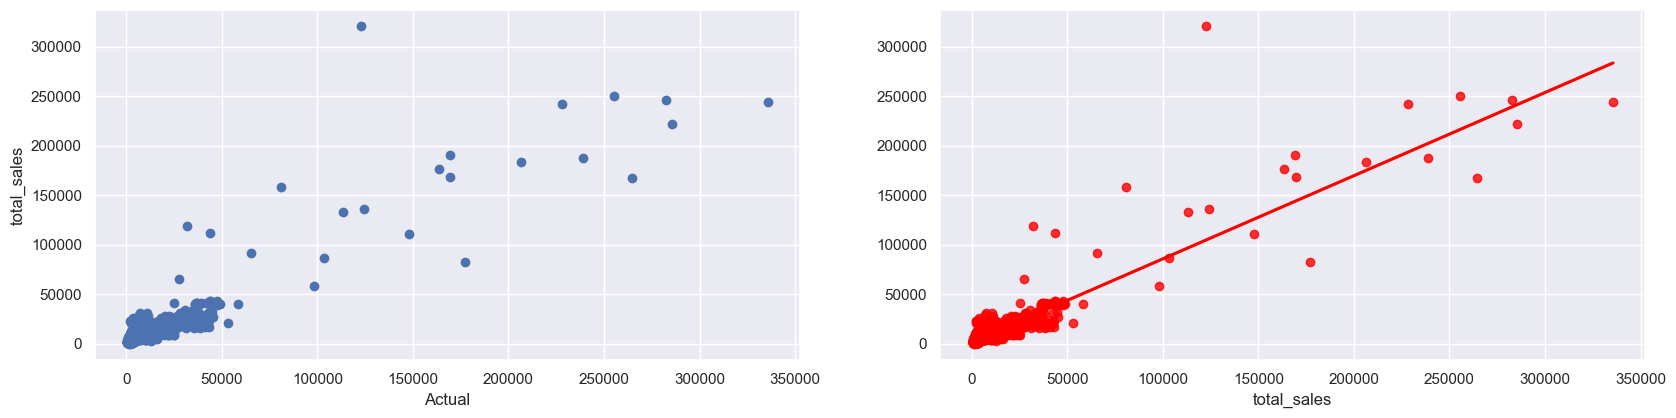

In [26]:
plt.subplot(221)
plt.scatter(ytest,preds);

plt.xlabel('Actual');
plt.ylabel('total_sales');

plt.subplot(222)
sns.regplot(x=ytest,y=preds,ci=None,color ='red');

---